# **INFO284 Machine Learning Exam, spring 2025**


# **Task 1 - Sentiment analysis**

## **Load data**

In [2]:
import pandas as pd

df = pd.read_csv('dataset/Hotel_Reviews.csv')

df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


## **Exploring the data**

### **Checking basic structure of the data**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

### **Overview of the distribution of the scores** 
We get an overview of the data to find out the max and min values of the reviewer scores and we also get an idea of the distribution of the reviewer scores.

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64
2.5
10.0


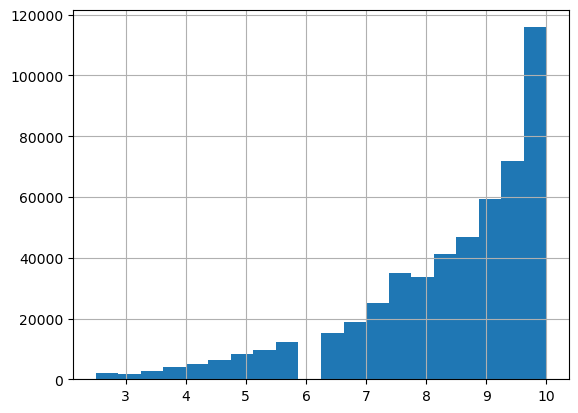

In [4]:
print(df['Reviewer_Score'].describe()) 

df['Reviewer_Score'].hist(bins=20)

print(df['Reviewer_Score'].min())
print(df['Reviewer_Score'].max())

From the histogram over we can see that the distribution of the scores is skewed towards the higher scores. This is not surprising as people tend to give higher scores when they are satisfied with a product or service.

## **Cleaning the review text**

Here we clean the review text. We remove 'No Negative' and 'No Positive' from the negative and positive reviews. 
Then we merge the negative and positive reviews into one column called 'Review'. This is done because it is easier to work with one column when doing the sentiment analysis.
After, we only keep the 'Review' and 'Reviewer_Score' columns because they are the only relevant columns for the sentiment analysis. All other columns are dropped. 
We also remove rows with missing values because they are not useful for the sentiment analysis.

In [5]:
df['Negative_Review'] = df['Negative_Review'].apply(lambda x: x.replace('No Negative', ''))
df['Positive_Review'] = df['Positive_Review'].apply(lambda x: x.replace('No Positive', ''))

df['Review'] = df['Negative_Review'] + ' ' + df['Positive_Review']

df = df[['Review','Reviewer_Score']] 

df = df.dropna()

df.head() 

,Review,Reviewer_Score
0,I am so angry that i made this post available...,2.9
1,No real complaints the hotel was great great...,7.5
2,Rooms are nice but for elderly a bit difficul...,7.1
3,My room was dirty and I was afraid to walk ba...,3.8
4,You When I booked with your company on line y...,6.7


## **Transforming review scores to binary values**

Here we add a new column called 'Sentiment' which is 1 if the reviewer score is greater than or exactly 6.25 and 0 otherwise. 6.25 is chosen because it is exactly the middle value of the given scores in the reviews (2.5 to 10). This is done to make the sentiment analysis a binary classification problem.

In [6]:
# Adjust the reviewer score to be binary numeric values
df['Sentiment'] = df['Reviewer_Score'].apply(lambda x: 1 if x >= 6.25 else 0)

# Here we split the data into two dataframes based on the sentiment 
df_majority = df[df['Sentiment'] == 1]
df_minority = df[df['Sentiment'] == 0]

## **Preprocessing the review text**

Here we preprocess the review text by lowercasing the text, removing special characters, punctuation using regular expression. We also remove stopwords, tokenize and lemmatize the text.

In [7]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) 
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['Review'] = df['Review'].apply(preprocess_text)
df.head()

,Review,Reviewer_Score,Sentiment
0,i am so angry that i made this post available...,2.9,0
1,no real complaints the hotel was great great...,7.5,1
2,rooms are nice but for elderly a bit difficul...,7.1,1
3,my room was dirty and i was afraid to walk ba...,3.8,0
4,you when i booked with your company on line y...,6.7,1


The text is now cleaned using regex and is ready for further processing.

### **Stopwords removal**

In [8]:
# remove stopwords

from nltk.corpus import stopwords

stop = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


### **Tokenization**

In [9]:
from nltk.tokenize import word_tokenize

def tokenize(text):
    return word_tokenize(text)

df['tokens'] = df['Review'].apply(tokenize)
df.head()

,Review,Reviewer_Score,Sentiment,tokens
0,angry made post available via possible sites u...,2.9,0,"[angry, made, post, available, via, possible, ..."
1,real complaints hotel great great location sur...,7.5,1,"[real, complaints, hotel, great, great, locati..."
2,rooms nice elderly bit difficult rooms two sto...,7.1,1,"[rooms, nice, elderly, bit, difficult, rooms, ..."
3,room dirty afraid walk barefoot floor looked c...,3.8,0,"[room, dirty, afraid, walk, barefoot, floor, l..."
4,booked company line showed pictures room thoug...,6.7,1,"[booked, company, line, showed, pictures, room..."


### **Lemmatization**

In [10]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    lemmatized_tokens = []
    for token in tokens:
        lemmatized_token = lemmatizer.lemmatize(token)
        lemmatized_tokens.append(lemmatized_token)
    return lemmatized_tokens

df['lemmatized'] = df['tokens'].apply(lemmatize)

df.head()

,Review,Reviewer_Score,Sentiment,tokens,lemmatized
0,angry made post available via possible sites u...,2.9,0,"[angry, made, post, available, via, possible, ...","[angry, made, post, available, via, possible, ..."
1,real complaints hotel great great location sur...,7.5,1,"[real, complaints, hotel, great, great, locati...","[real, complaint, hotel, great, great, locatio..."
2,rooms nice elderly bit difficult rooms two sto...,7.1,1,"[rooms, nice, elderly, bit, difficult, rooms, ...","[room, nice, elderly, bit, difficult, room, tw..."
3,room dirty afraid walk barefoot floor looked c...,3.8,0,"[room, dirty, afraid, walk, barefoot, floor, l...","[room, dirty, afraid, walk, barefoot, floor, l..."
4,booked company line showed pictures room thoug...,6.7,1,"[booked, company, line, showed, pictures, room...","[booked, company, line, showed, picture, room,..."


## **Splitting the data into training and test sets**

In [11]:

from sklearn.model_selection import train_test_split
# Split the data into training and test sets (80% training, 20% testing)

X = df['lemmatized'].apply(lambda x: ' '.join(x))

y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## **MultinomialNB**

### **MultinomialNB with TF-IDF vectorizer**

The first model we will use for classifiying hotel reviews is MultinomialNB with TF-IDF vectorizer. We will use the TF-IDF vectorizer to convert the text data into numerical data that the model can work with. This model is chosen because it is a simple and fast model that is often used for text classification tasks. Later in the notebook we will also run a MultinomialNB model with CountVectorizer to compare the results.

#### **Importing necessary libraries**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#### **Creating pipeline**
Because we are using TF-IDF vectorizer, it is most beneficial to use a pipeline because we are transforming the text data based on statistical properties of the dataset. Because of this, it's essential to ensure that all steps (vectorization and model training) are done correctly and consistently. 

In [13]:
pipe = make_pipeline(TfidfVectorizer(min_df = 5, max_df=0.8, norm=None), MultinomialNB())

param_grid = {'multinomialnb__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)
default_score = (grid.score(X_test, y_test))

print(f'Default score: {default_score}')

{'multinomialnb__alpha': 100, 'tfidfvectorizer__ngram_range': (1, 3)}
0.9089435032356576
Default score: 0.9098479854190096


#### **Finding best threshold for the model**

Optimal Threshold: 0.9999999999991189
              precision    recall  f1-score   support

           0       0.32      0.62      0.42     10552
           1       0.95      0.85      0.90     92596

    accuracy                           0.83    103148
   macro avg       0.64      0.74      0.66    103148
weighted avg       0.89      0.83      0.85    103148



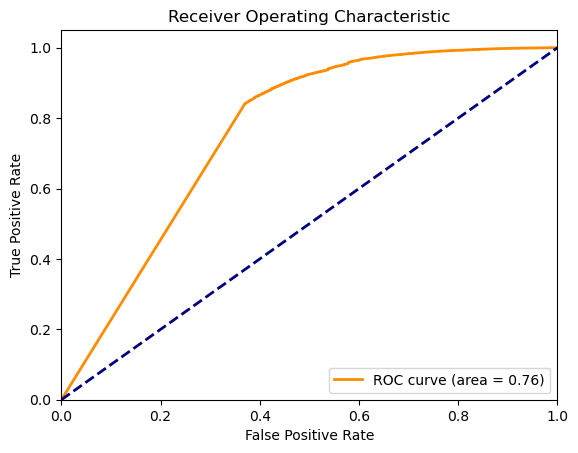

{'best_params': {'multinomialnb__alpha': 100, 'tfidfvectorizer__ngram_range': (1, 3)}, 'best_score': 0.9089435032356576, 'default_threshold_score': 0.9098479854190096, 'optimal_threshold': 0.9999999999991189, 'classification_report': {'0': {'precision': 0.320363671913188, 'recall': 0.6211144806671721, 'f1-score': 0.42270235407932927, 'support': 10552.0}, '1': {'precision': 0.9516507437416858, 'recall': 0.8498423258024105, 'f1-score': 0.897869767123444, 'support': 92596.0}, 'accuracy': 0.8264435568309614, 'macro avg': {'precision': 0.6360072078274369, 'recall': 0.7354784032347913, 'f1-score': 0.6602860606013866, 'support': 103148.0}, 'weighted avg': {'precision': 0.8870703235499777, 'recall': 0.8264435568309614, 'f1-score': 0.849260326877957, 'support': 103148.0}}}


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = grid.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_optimal))

print(confusion_matrix(y_test, y_pred_optimal))

roc_auc = roc_auc_score(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

results = {
    '\nbest_params': grid.best_params_,
    '\nbest_score': grid.best_score_,
    '\ndefault_threshold_score': default_score,
    '\noptimal_threshold': optimal_threshold,
    '\nclassification_report': classification_report(y_test, y_pred_optimal, output_dict=True)
}

print(results)

{'multinomialnb__alpha': 100, 'tfidfvectorizer__ngram_range': (1, 3)}
0.9072784119828402
0.9090917904370419

#### **ROC AUC score for the default model**

              precision    recall  f1-score   support

           0       0.59      0.37      0.46     10552
           1       0.93      0.97      0.95     92596

    accuracy                           0.91    103148
   macro avg       0.76      0.67      0.71    103148
weighted avg       0.90      0.91      0.90    103148



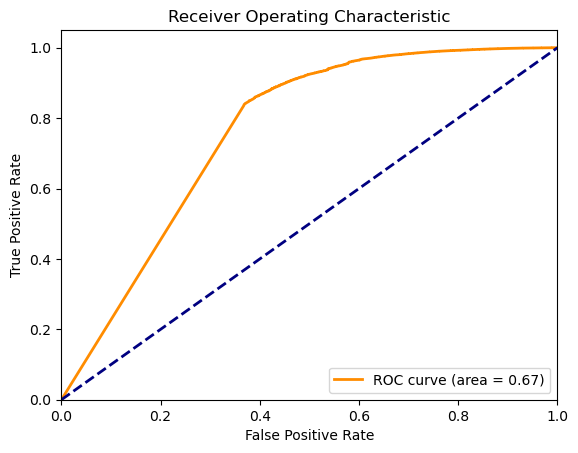

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### **Heat map of mean cross-validation accuracy as a function of the parameters ngram_range and alpha**

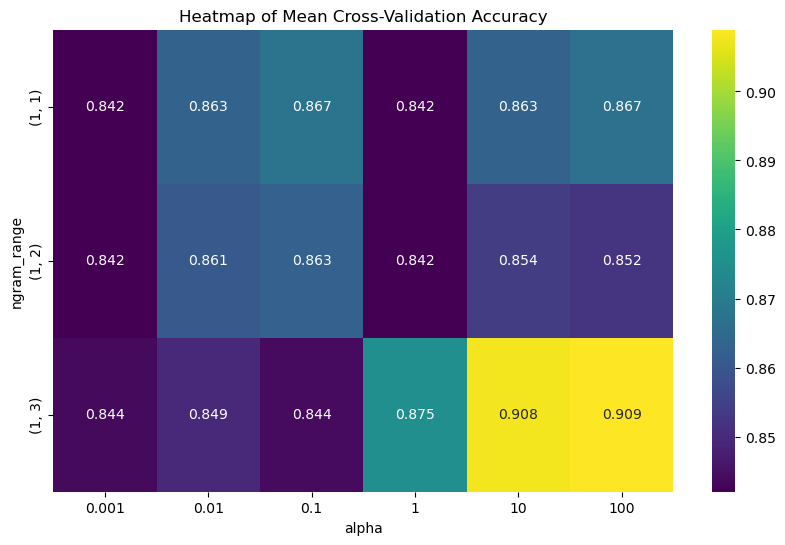

In [13]:
# Get the number of unique values for each parameter
n_ngram_range = len(param_grid['tfidfvectorizer__ngram_range'])
n_alpha = len(param_grid['multinomialnb__alpha'])

# Reshape the scores array based on the number of unique values
scores = grid.cv_results_['mean_test_score'][:n_ngram_range * n_alpha].reshape(n_ngram_range, n_alpha)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", xticklabels=param_grid['multinomialnb__alpha'], yticklabels=param_grid['tfidfvectorizer__ngram_range'], cmap='viridis')
plt.xlabel('alpha')
plt.ylabel('ngram_range')
plt.title('Heatmap of Mean Cross-Validation Accuracy')
plt.show()

From the heatmap we can see that the parameters that give the best accuracy are ngram_range = (1, 3) and alpha = 100. This aligns with the parameters that we found to give the best accuracy in the grid search.

#### **Printing and plotting the features with the highest and lowest tf-idf**

Features with lowest tfidf:
['location friendly' 'location near' 'location friendly staff'
 'location nice' 'staff helpful friendly' 'staff clean'
 'hotel great location' 'room friendly' 'nothing location'
 'staff great location' 'clean good' 'location breakfast'
 'staff extremely helpful' 'hotel friendly' 'friendly staff good'
 'polite helpful' 'room clean comfortable' 'comfy room' 'helpful location'
 'helpful friendly staff' 'location easy' 'great location friendly'
 'staff comfortable' 'location comfortable' 'location helpful']
Features with highest tfidf: 
['de' 'massage' 'amount' 'woman' 'wife' 'gal' 'ho' 'doctor' 'booking'
 'shift receptionist' 'egg' 'lara' 'reservation' 'var' 'wing' 'det'
 'bellhop' 'new wing' 'panini' 'jason' 'package' 'vi' 'guestroom' 'och'
 'nada']


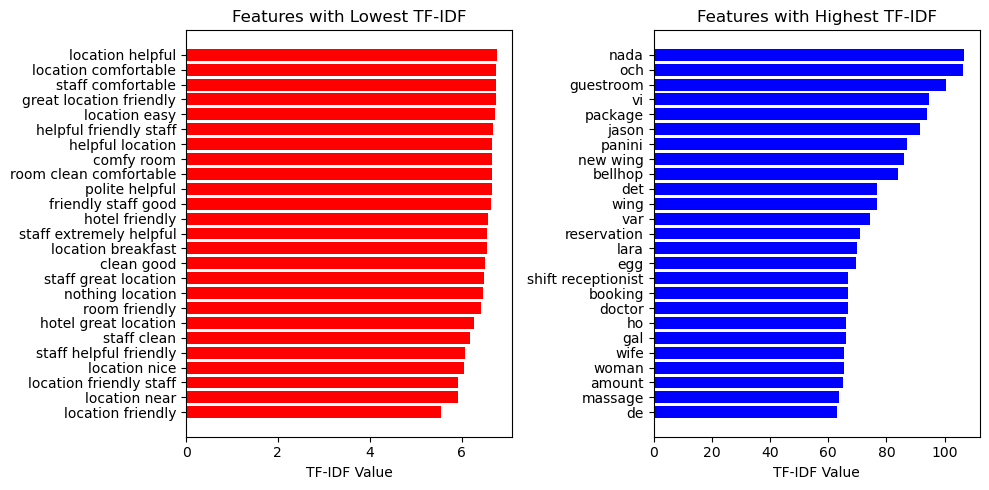

In [14]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train_transformed = vectorizer.transform(X_train)
max_value = X_train_transformed.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names_out())
print("Features with lowest tfidf:\n{}".format(feature_names[sorted_by_tfidf[:25]]))
print("Features with highest tfidf: \n{}".format(feature_names[sorted_by_tfidf[-25:]]))
plt.figure(figsize=(10, 5))

# Plot features with lowest tfidf
plt.subplot(1, 2, 1)
plt.barh(feature_names[sorted_by_tfidf[:25]], max_value[sorted_by_tfidf[:25]], color='red')
plt.xlabel('TF-IDF Value')
plt.title('Features with Lowest TF-IDF')

# Plot features with highest tfidf
plt.subplot(1, 2, 2)
plt.barh(feature_names[sorted_by_tfidf[-25:]], max_value[sorted_by_tfidf[-25:]], color='blue')
plt.xlabel('TF-IDF Value')
plt.title('Features with Highest TF-IDF')

plt.tight_layout()
plt.show()

The visualization above shows the 25 features with the highest and lowest tf-idf values. The features with the highest tf-idf values are the most important features for the model to classify the reviews. The features with the lowest tf-idf values are the least important features for the model to classify the reviews.

#### **Visualizing the top features that are most indicative of positive and negative reviews**

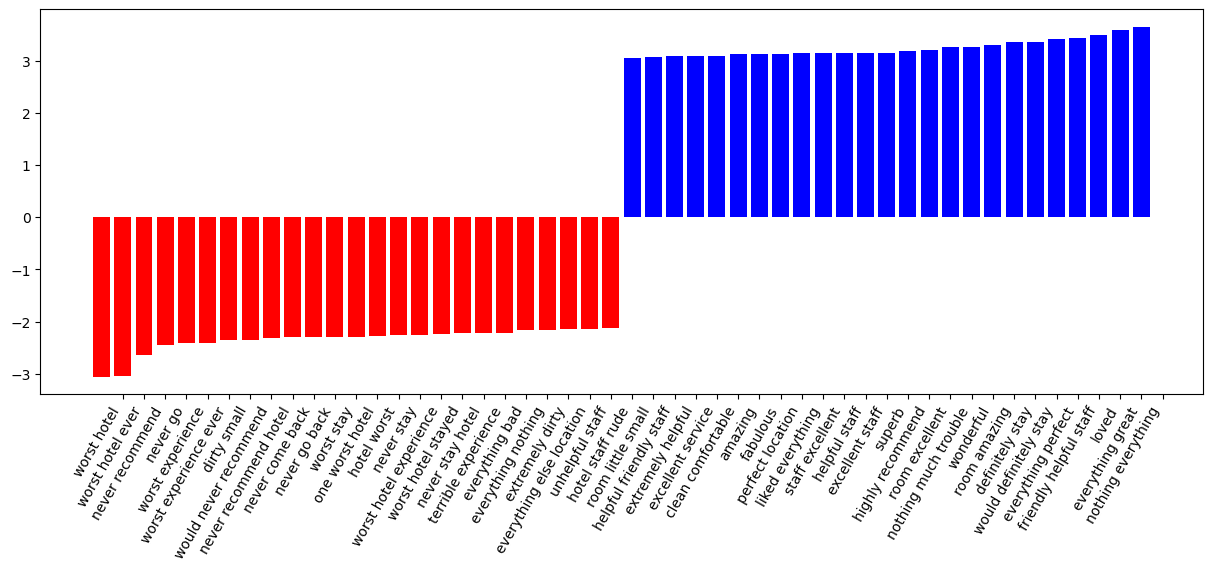

In [15]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    coef = classifier.feature_log_prob_[1] - classifier.feature_log_prob_[0]
    top_positive_coefficients = np.argsort(coef)[-n_top_features:]
    top_negative_coefficients = np.argsort(coef)[:n_top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train_transformed = vectorizer.transform(X_train)
clf = grid.best_estimator_.named_steps['multinomialnb']
visualize_coefficients(clf, vectorizer.get_feature_names_out())

The visualization show the top 20 features that are most indicative of positive and negative reviews. The features are sorted by their coefficient values. The features with the highest coefficient values are most indicative of positive reviews, while the features with the lowest coefficient values are most indicative of negative reviews.

### **MultinomialNB with CountVectorizer**

#### **CountVectorizer & Naive Bayes Training**

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(min_df=5, max_df=0.8)

X_train_mnb_cv = count_vectorizer.fit_transform(X_train) 
X_test_mnb_cv = count_vectorizer.transform(X_test)

mnb_cv = MultinomialNB()

#### **Cross Validation**

In [17]:
cv_scores_cv = cross_val_score(mnb_cv, X_train_mnb_cv, y_train, cv=5)
print(f"Cross-validation scores (CountVectorizer): {cv_scores_cv}")
print(f"Mean cross-validation score (CountVectorizer): {cv_scores_cv.mean():.4f}")

Cross-validation scores (CountVectorizer): [0.88750333 0.88580673 0.88833951 0.88787901 0.88969679]
Mean cross-validation score (CountVectorizer): 0.8878


#### **Hyperparameter tuning with GridSearchCV and Model Evaluation**

In [18]:
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False],
}

grid_search = GridSearchCV(estimator=mnb_cv, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train_mnb_cv, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")

best_mnb_cv = grid_search.best_estimator_

y_pred_cv = best_mnb_cv.predict(X_test_mnb_cv)

accuracy = accuracy_score(y_test, y_pred_cv)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_cv))

Best hyperparameters: {'alpha': 10.0, 'fit_prior': True}
Accuracy: 0.9001
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.50      0.50     10552
           1       0.94      0.95      0.94     92596

    accuracy                           0.90    103148
   macro avg       0.73      0.72      0.72    103148
weighted avg       0.90      0.90      0.90    103148



### **Comparing MultiNomialNB with TF-IDF and CountVectorizer**

In [ ]:
y_pred_tfidf = grid.predict(X_test)

accuracy_scores = {
    "TF-IDF": accuracy_score(y_test, y_pred_tfidf),
    "CountVectorizer": accuracy_score(y_test, y_pred_cv)
}

print("Model Comparison:")
for model, score in accuracy_scores.items():
    print(f"{model}: {score:.4f}")

Model Comparison:
TF-IDF: 0.9072
CountVectorizer: 0.9001


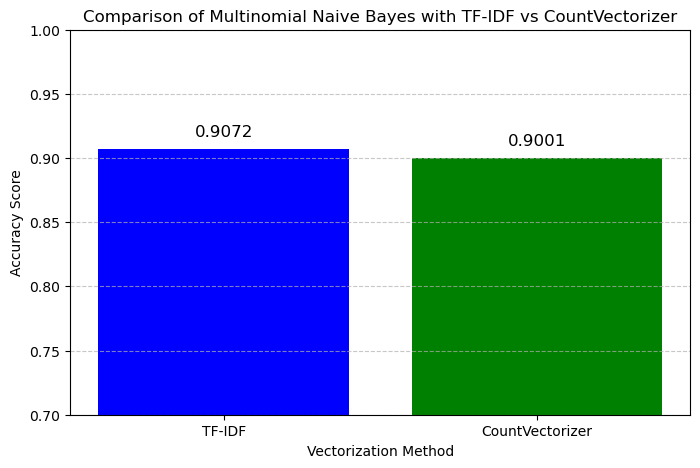

In [ ]:
# Visualization of accuracy scores
models = list(accuracy_scores.keys())
scores = list(accuracy_scores.values())

plt.figure(figsize=(8, 5))
plt.bar(models, scores, color=['blue', 'green'])

plt.xlabel("Vectorization Method")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Multinomial Naive Bayes with TF-IDF vs CountVectorizer")
plt.ylim(0.7, 1.0)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)

plt.show()

## **Complement Naive Bayes with TF-IDF vectorizer**

### **Creating pipeline**

In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import KFold

pipe = make_pipeline(TfidfVectorizer(min_df = 5, max_df=0.8, norm=None), ComplementNB())

param_grid = {'complementnb__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=kfold, stratify=y)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_test, y_test))

{'complementnb__alpha': 100, 'tfidfvectorizer__ngram_range': (1, 3)}
0.9059768777721224
0.9072400822119673


### **Heat map of mean cross-validation accuracy as a function of the parameters ngram_range and alpha**

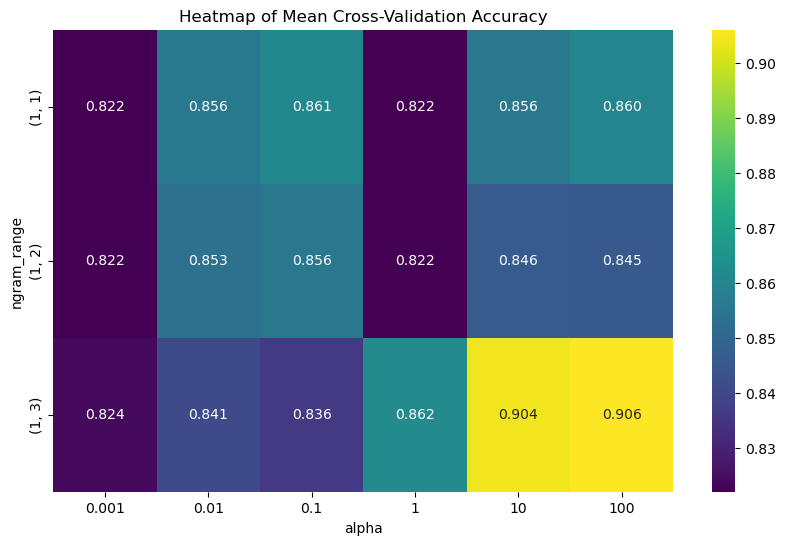

In [21]:
# Get the number of unique values for each parameter
n_ngram_range = len(param_grid['tfidfvectorizer__ngram_range'])
n_alpha = len(param_grid['complementnb__alpha'])

# Reshape the scores array based on the number of unique values
scores = grid.cv_results_['mean_test_score'][:n_ngram_range * n_alpha].reshape(n_ngram_range, n_alpha)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", xticklabels=param_grid['complementnb__alpha'], yticklabels=param_grid['tfidfvectorizer__ngram_range'], cmap='viridis')
plt.xlabel('alpha')
plt.ylabel('ngram_range')
plt.title('Heatmap of Mean Cross-Validation Accuracy')
plt.show()

### **Printing and plotting the features with the highest and lowest tf-idf**

Features with lowest tfidf:
['location friendly' 'location near' 'location friendly staff'
 'location nice' 'staff helpful friendly' 'staff clean'
 'hotel great location' 'room friendly' 'nothing location'
 'staff great location' 'clean good' 'location breakfast'
 'staff extremely helpful' 'hotel friendly' 'friendly staff good'
 'polite helpful' 'room clean comfortable' 'comfy room' 'helpful location'
 'helpful friendly staff' 'location easy' 'great location friendly'
 'staff comfortable' 'location comfortable' 'location helpful']
Features with highest tfidf: 
['de' 'massage' 'amount' 'woman' 'wife' 'gal' 'ho' 'doctor' 'booking'
 'shift receptionist' 'egg' 'lara' 'reservation' 'var' 'wing' 'det'
 'bellhop' 'new wing' 'panini' 'jason' 'package' 'vi' 'guestroom' 'och'
 'nada']


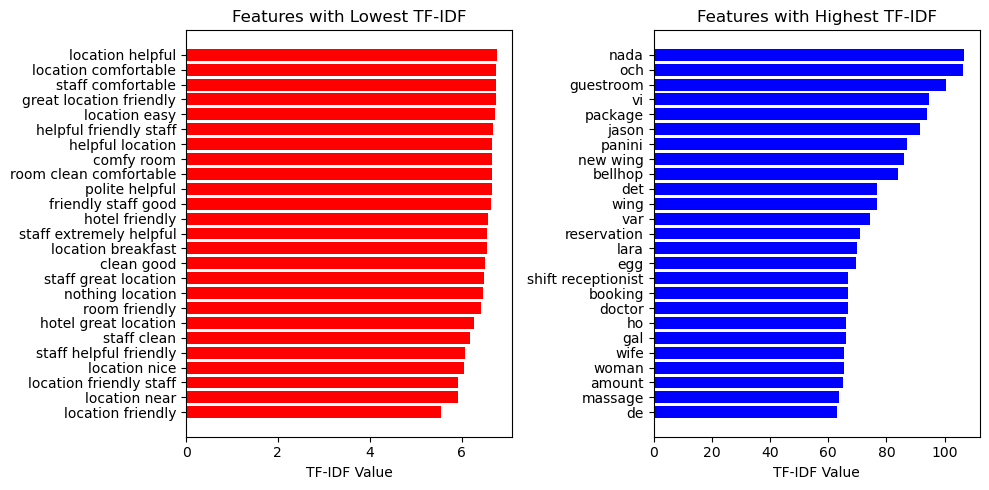

In [22]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train_transformed = vectorizer.transform(X_train)
max_value = X_train_transformed.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names_out())
print("Features with lowest tfidf:\n{}".format(feature_names[sorted_by_tfidf[:25]]))
print("Features with highest tfidf: \n{}".format(feature_names[sorted_by_tfidf[-25:]]))
plt.figure(figsize=(10, 5))

# Plot features with lowest tfidf
plt.subplot(1, 2, 1)
plt.barh(feature_names[sorted_by_tfidf[:25]], max_value[sorted_by_tfidf[:25]], color='red')
plt.xlabel('TF-IDF Value')
plt.title('Features with Lowest TF-IDF')

# Plot features with highest tfidf
plt.subplot(1, 2, 2)
plt.barh(feature_names[sorted_by_tfidf[-25:]], max_value[sorted_by_tfidf[-25:]], color='blue')
plt.xlabel('TF-IDF Value')
plt.title('Features with Highest TF-IDF')

plt.tight_layout()
plt.show()

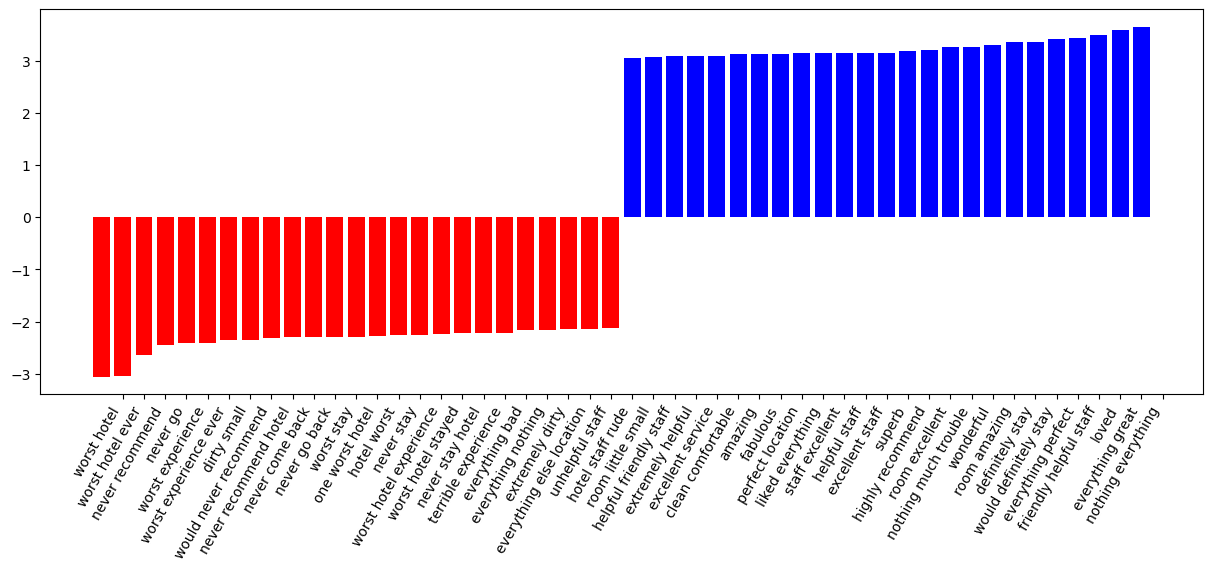

In [23]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    coef = classifier.feature_log_prob_[1] - classifier.feature_log_prob_[0]
    top_positive_coefficients = np.argsort(coef)[-n_top_features:]
    top_negative_coefficients = np.argsort(coef)[:n_top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train_transformed = vectorizer.transform(X_train)
clf = grid.best_estimator_.named_steps['complementnb']
visualize_coefficients(clf, vectorizer.get_feature_names_out())
